# Capstone 1 : NN2

# Medical Image Analysis with CNN

# Define Project Objectives

In this project, 

you will build a Convolutional Neural Network (CNN) model that can analyze medical images, such as X-rays or MRIs, to detect diseases or abnormalities. 

You will start by exploring a dataset of medical images, such as the Chest X-Ray Images dataset or the NIH Clinical Center dataset, and performing EDA to gain insights into the data. 

You will analyze the correlation between different features and identify any outliers or missing values that need to be handled.

You will then `preprocess the dataset`, `splitting it into training and testing sets`, and `normalizing the pixel values`. 

You will `build a CNN model` using PyTorch or `Tensorflow` that can analyze the input medical images and `detect diseases or abnormalities`. 

You will experiment with different neural network architectures, `activation functions`, and `learning rates` to find the best model for the task.

Finally, you will evaluate the performance of your model using metrics such as `accuracy`, `precision`, `recall`, and `F1 score`, and visualize the results using `confusion matrices` or other visualization techniques to see how well the model performs on different medical conditions.

Dataset URL:

`Chest X-Ray Images` dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

The Chest X-Ray Images dataset contains `5856 images` with binary classes: `normal or pneumonia`.

`NIH Clinical Center` dataset: https://nihcc.app.box.com/v/ChestXray-NIHCC

The NIH Clinical Center dataset contains over `100,000 chest X-ray images` with `14 different disease labels`.

This project will give you hands-on experience with CNN and medical image analysis, and will help you develop skills in coding with PyTorch and Tensorflow. 

It will also give you the opportunity to experiment with different neural network architectures and activation functions to find the best model for the task.

Verify GPU

In [2]:
# import tensorflow as tf

In [3]:
# "GPU", "available" if tf.test.gpu_device_name() else "not available"

# Data Acquisition

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [5]:
os.getcwd()

'/kaggle/working'

In [6]:
# !pip install kaggle

Upload the kaggle.json file that you downloaded

In [7]:
# def download_kaggle_dataset(username, dataset_name, target_dir='/content'):
#     # Step 1: Upload kaggle.json
#     uploaded = files.upload()

#     # Step 2: Move the uploaded kaggle.json file to the appropriate directory
#     os.makedirs('/root/.kaggle', exist_ok=True)
#     os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

#     # Step 3: Set permissions for the Kaggle API key
#     !chmod 600 /root/.kaggle/kaggle.json

#     # Step 4: Download the dataset from Kaggle
#     download_command = f'kaggle datasets download -d {username}/{dataset_name} -p {target_dir}'
#     !{download_command}

#     # Step 5: Unzip the downloaded dataset
#     unzip_command = f'unzip -q {target_dir}/{dataset_name}.zip -d {target_dir}/dataset'
#     !{unzip_command}

# download_kaggle_dataset(username='paultimothymooney', dataset_name='chest-xray-pneumonia', target_dir='/content')


Create subplots and Loop through train, val, and test sets

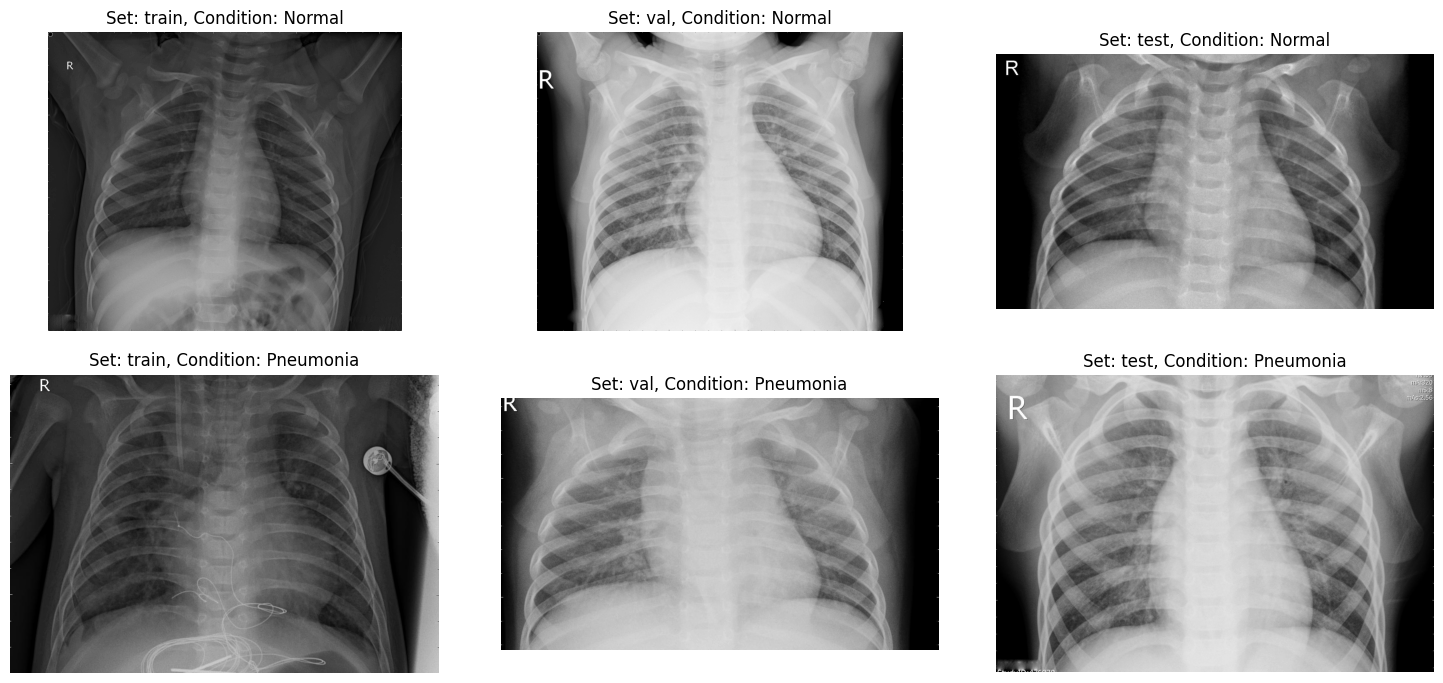

In [8]:
def show_data(input_path):
    fig, ax = plt.subplots(2, 3, figsize = (15,7))
    ax= ax.ravel()
    plt.tight_layout()

    for i, _set in enumerate(['train', 'val', 'test']):
        set_path = os.path.join(input_path, _set) # "chest_xray/train" or "chest_xray/val" or "chest_xray/test"
        # print(set_path)
        normal_img_path = os.path.join(set_path, 'NORMAL', os.listdir(os.path.join(set_path, 'NORMAL'))[0])
        pneumonia_img_path = os.path.join(set_path, 'PNEUMONIA', os.listdir(os.path.join(set_path, 'PNEUMONIA'))[0])
        
        if os.path.isfile(normal_img_path) and os.path.isfile(pneumonia_img_path):
            # Normal 
            ax[i].imshow(plt.imread(normal_img_path), cmap='gray')
            ax[i].set_title(f'Set: {_set}, Condition: Normal')
            ax[i].axis('off')
            # Pneumonia
            ax[i+3].imshow(plt.imread(pneumonia_img_path), cmap='gray')
            ax[i+3].set_title(f'Set: {_set}, Condition: Pneumonia')
            ax[i+3].axis('off')
        else:
            print(f"Image not found for {_set} set")

    plt.show()

# base_dir = "chest_xray/"
# base_dir = "dataset/chest_xray/"
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'
show_data(base_dir)

In [9]:
for _set in ['train', 'val', 'test']:
    no_normal = len(os.listdir(base_dir + _set + '/NORMAL'))
    no_pneumonia = len(os.listdir(base_dir + _set + '/PNEUMONIA'))
    print(f"Set: {_set}, normal images: {no_normal}, pneumonia images: {no_pneumonia}")

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


# Data Preprocessing:

In [10]:
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
def process_data(img_dims, batch_size):

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        zoom_range=0.3,
        vertical_flip=True,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_set = train_datagen.flow_from_directory(
        directory=base_dir + "/train",
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
    )

    test_set = test_datagen.flow_from_directory(
        directory=base_dir + "/test",
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(base_dir + 'test' + cond)):
            img = plt.imread(base_dir + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype(np.float32) / 255
            
            label = 0 if cond == '/NORMAL/' else 1
            
            test_data.append(img)
            test_labels.append(label)
    
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_set, test_set, test_data, test_labels

img_dims = 150
batch_size= 32
train_gen, test_gen, test_data, test_labels = process_data(img_dims=img_dims, batch_size=batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
x_train, y_train = next(train_gen)
x_test, y_test = next(test_gen)

# EDA

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


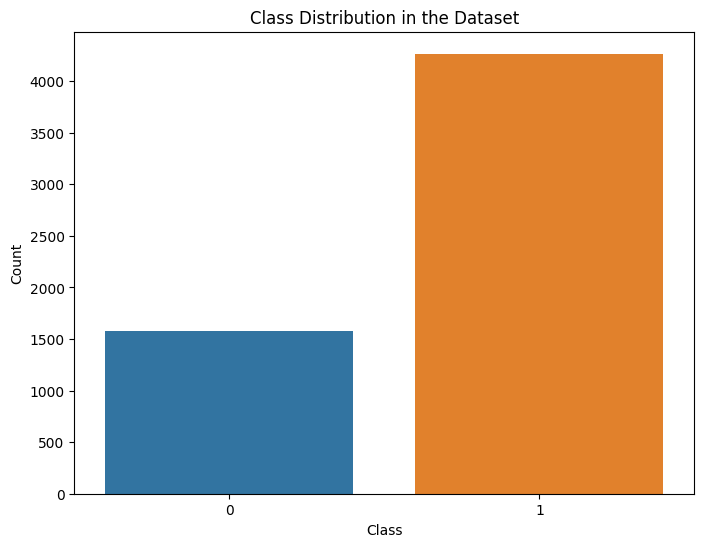

In [14]:
all_labels = np.concatenate([train_gen.classes, test_labels])
df = pd.DataFrame({"class": all_labels})

plt.figure(figsize=(8, 6))
sns.countplot(x="class", data=df)
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# CNN Model Architecture and Hyperparameter tuning

In [15]:
!pip install scikeras

In [16]:
from keras import models, layers, optimizers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf

In [17]:
def build_CNN_model(img_dims=150, units=128, dropout_rate=0.5):
    model = models.Sequential()
    # firrst conv block
    model.add(layers.Conv2D(filters=units,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same',
                            input_shape=(img_dims, img_dims, 3)))
    model.add(layers.Conv2D(filters=units,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same')) 
    model.add(layers.MaxPooling2D(pool_size=(2,3)))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units,
                           activation='relu'))
    model.add(layers.Dropout(rate=dropout_rate))

    # output layer 
    model.add(layers.Dense(units=1,
                           activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


seed = 7
tf.random.set_seed(seed)

parameter grid for Random Search

In [18]:
param_grid = {
    'units': [16, 32, 64],
    'dropout_rate': [0.25, 0.5],
}

In [19]:
cnn_model = KerasClassifier(build_fn=build_CNN_model,
                            img_dims=150, 
                            units=32, 
                            dropout_rate=0.5,
                            epochs=5,
                            batch_size=batch_size,
                            verbose=0)

cnn_model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'img_dims', 'units', 'dropout_rate', 'class_weight'])

In [20]:
random_search_cnn = RandomizedSearchCV(estimator= cnn_model, 
                                       param_distributions=param_grid,
                                       cv=3)

random_search_cnn

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, build_fn=<function build_CNN_model at 0x7df43e503b50>, dropout_rate=0.5, epochs=5, img_dims=150, units=32, verbose=0),
                   param_distributions={'dropout_rate': [0.25, 0.5],
                                        'units': [16, 32, 64]})

In [21]:
random_search_results_cnn = random_search_cnn.fit(x_train, y_train)
random_search_results_cnn

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wra

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, build_fn=<function build_CNN_model at 0x7df43e503b50>, dropout_rate=0.5, epochs=5, img_dims=150, units=32, verbose=0),
                   param_distributions={'dropout_rate': [0.25, 0.5],
                                        'units': [16, 32, 64]})

In [22]:
pd.DataFrame(random_search_results_cnn.cv_results_)[["params"]]

,params
0,"{'units': 16, 'dropout_rate': 0.25}"
1,"{'units': 32, 'dropout_rate': 0.25}"
2,"{'units': 64, 'dropout_rate': 0.25}"
3,"{'units': 16, 'dropout_rate': 0.5}"
4,"{'units': 32, 'dropout_rate': 0.5}"
5,"{'units': 64, 'dropout_rate': 0.5}"


Best parameters

In [23]:
random_search_results_cnn.best_params_

{'units': 64, 'dropout_rate': 0.25}

Best score

In [24]:
round(random_search_results_cnn.best_score_*100)

78

# VGG16 Model Architecture and Hyperparameter tuning

In [25]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D

In [26]:
def build_VGG16_model(img_dims=150, units=128, dropout_rate=0.5):
    base_model = VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(img_dims, img_dims, 3))
    model = models.Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(layers.Dense(units=units, activation='relu'))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

parameter grid for Random Search

In [27]:
param_dist_vgg16 = {
    'units': [16, 64, 128],
    'dropout_rate': [0.25, 0.5],
}

In [28]:
vgg16_model = KerasClassifier(build_fn=build_VGG16_model, 
                              img_dims=img_dims, 
                              units=32, 
                              dropout_rate=0.5,
                              epochs=5, 
                              batch_size=batch_size, 
                              verbose=0)
vgg16_model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'img_dims', 'units', 'dropout_rate', 'class_weight'])

In [29]:
random_search_vgg16 = RandomizedSearchCV(vgg16_model, 
                                         param_distributions=param_dist_vgg16, 
                                         cv=3)

random_search_vgg16

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, build_fn=<function build_VGG16_model at 0x7df3f046e560>, dropout_rate=0.5, epochs=5, img_dims=150, units=32, verbose=0),
                   param_distributions={'dropout_rate': [0.25, 0.5],
                                        'units': [16, 64, 128]})

In [30]:
random_search_results_vgg16 = random_search_vgg16.fit(x_train, y_train)

random_search_results_vgg16

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wra

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, build_fn=<function build_VGG16_model at 0x7df3f046e560>, dropout_rate=0.5, epochs=5, img_dims=150, units=32, verbose=0),
                   param_distributions={'dropout_rate': [0.25, 0.5],
                                        'units': [16, 64, 128]})

In [31]:
pd.DataFrame(random_search_results_vgg16.cv_results_)[["params"]]

,params
0,"{'units': 16, 'dropout_rate': 0.25}"
1,"{'units': 64, 'dropout_rate': 0.25}"
2,"{'units': 128, 'dropout_rate': 0.25}"
3,"{'units': 16, 'dropout_rate': 0.5}"
4,"{'units': 64, 'dropout_rate': 0.5}"
5,"{'units': 128, 'dropout_rate': 0.5}"


Best parameters

In [32]:
random_search_results_vgg16.best_params_

{'units': 16, 'dropout_rate': 0.25}

Best score

In [33]:
round(random_search_results_vgg16.best_score_*100)

78

# ResNet Model Architecture and Hyperparameter tuning

In [34]:
from keras.applications import ResNet50

In [35]:
def build_ResNet_model(img_dims=150, units=128, dropout_rate=0.5):
    base_model = ResNet50(weights='imagenet', 
                          include_top=False, 
                          input_shape=(img_dims, img_dims, 3))
    model = models.Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(layers.Dense(units=units, 
                           activation='relu'))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(units=1, 
                           activation='sigmoid'))
    
    model.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

parameter grid for Random Search

In [36]:
resent_params_dict = {
    'units': [16, 64, 128],
    'dropout_rate': [0.25, 0.5]
}

In [37]:
resnet_model = KerasClassifier(build_fn=build_ResNet_model, 
                               img_dims=img_dims, 
                               units=32, 
                               dropout_rate=0.5,
                               epochs=5,
                               batch_size=batch_size, verbose=0)
resnet_model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'img_dims', 'units', 'dropout_rate', 'class_weight'])

In [38]:
resnet_random_search = RandomizedSearchCV(resnet_model,
                                          param_distributions=resent_params_dict,
                                          cv=3)

resnet_random_search

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, build_fn=<function build_ResNet_model at 0x7df43df2bd90>, dropout_rate=0.5, epochs=5, img_dims=150, units=32, verbose=0),
                   param_distributions={'dropout_rate': [0.25, 0.5],
                                        'units': [16, 64, 128]})

In [39]:
resnet_random_search_results = resnet_random_search.fit(x_train, y_train)
resnet_random_search_results

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wra

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=32, build_fn=<function build_ResNet_model at 0x7df43df2bd90>, dropout_rate=0.5, epochs=5, img_dims=150, units=32, verbose=0),
                   param_distributions={'dropout_rate': [0.25, 0.5],
                                        'units': [16, 64, 128]})

In [40]:
pd.DataFrame(resnet_random_search_results.cv_results_)[["params"]]

,params
0,"{'units': 16, 'dropout_rate': 0.25}"
1,"{'units': 64, 'dropout_rate': 0.25}"
2,"{'units': 128, 'dropout_rate': 0.25}"
3,"{'units': 16, 'dropout_rate': 0.5}"
4,"{'units': 64, 'dropout_rate': 0.5}"
5,"{'units': 128, 'dropout_rate': 0.5}"


Best parameters

In [41]:
resnet_random_search_results.best_params_

{'units': 16, 'dropout_rate': 0.25}

Best score

In [42]:
round(resnet_random_search_results.best_score_*100)

78

# Callbacks

In [43]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [56]:
checkpoint = ModelCheckpoint(filepath='best_weights.h5', 
                             save_best_only=True,
                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=2,
                              mode='max')

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.1,
                           patience=1,
                           mode='min')

# Training the Model:

In [45]:
def train_model(model, train_gen, test_gen, epochs=10, callbacks=None):
    hist = model.fit_generator(
        train_gen,
        steps_per_epoch=train_gen.samples // batch_size,
        epochs=epochs,
        validation_data=test_gen,
        validation_steps=test_gen.samples // batch_size,
        callbacks= callbacks
    )
    return hist

# Displaying Metrics for trian and val set

In [46]:
def show_metrics(hist):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax = ax.ravel()
    plt.tight_layout()

    for i, metr in enumerate(['accuracy', 'loss']):
        ax[i].plot(hist.history[metr])
        ax[i].plot(hist.history['val_' + metr])
        ax[i].set_title(f'Model {metr}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(metr)
        ax[i].legend(['train', 'test'])

    plt.show()

# Evaluation Metrics for test set

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [48]:
def evaluate_model(model, test_data, test_labels, hist):
    preds_labels = model.predict(test_data)
    test_acc = np.round(accuracy_score(test_labels, 
                                       np.round(preds_labels)) * 100, 2)
    train_acc = np.round((hist.history['accuracy'][-1] * 100, 2))[0]
    cr = classification_report(test_labels, 
                               np.round(preds_labels))
    cm = confusion_matrix(test_labels, 
                          np.round(preds_labels))
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.show()
    return preds_labels, test_acc, train_acc, cr, cm, cmd

# Test Multiple models arch and choose the best

CNN Model

/tmp/ipykernel_16744/1243631348.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/15
163/163 [==============================] - 82s 496ms/step - loss: 0.9043 - accuracy: 0.7241 - val_loss: 0.5831 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - 0s 11ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


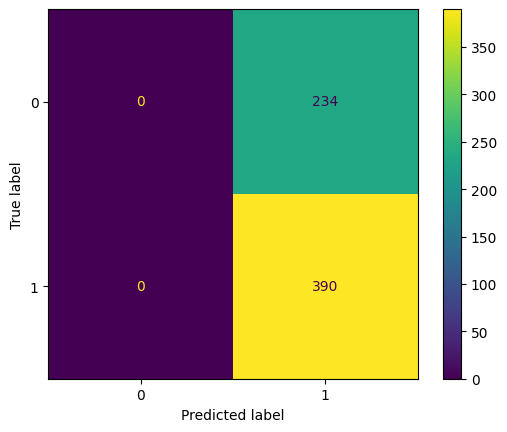

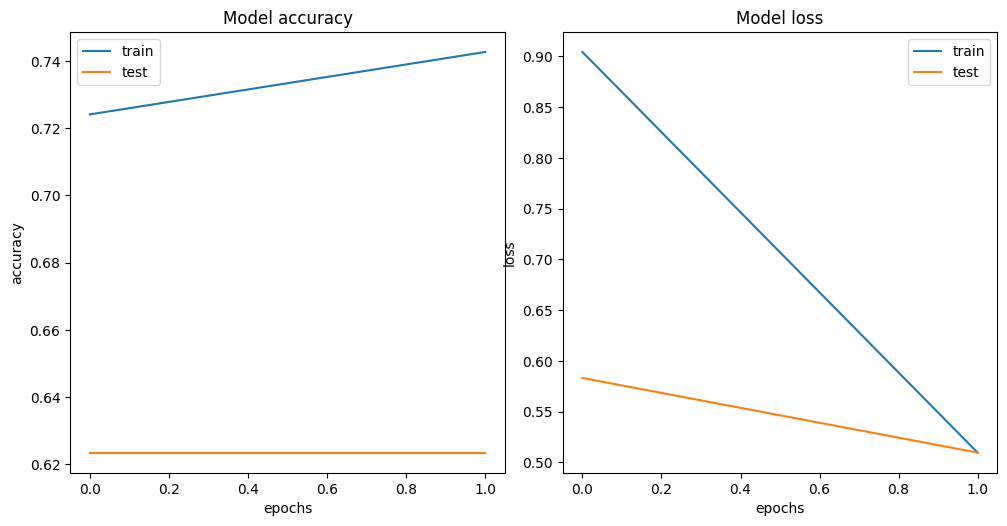

In [57]:
cnn_model = build_CNN_model(img_dims, 
                            random_search_results_cnn.best_params_['units'],
                            random_search_results_cnn.best_params_['dropout_rate'])

cnn_hist = train_model(cnn_model, 
                       train_gen, 
                       test_gen, 
                       epochs=15,
                       callbacks=[checkpoint, reduce_lr, early_stop])
cnn_preds, cnn_test_acc, cnn_train_acc, cnn_cr, cnn_cm, cnn_cmd = evaluate_model(cnn_model, 
                                                                test_data, 
                                                                test_labels, 
                                                                cnn_hist)
show_metrics(cnn_hist)

In [58]:
print("CNN Model Classification Report:")
print(cnn_cr)

CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



Vgg16 Model

/tmp/ipykernel_16744/1243631348.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/15
163/163 [==============================] - 81s 468ms/step - loss: 0.7752 - accuracy: 0.7506 - val_loss: 0.5880 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 76s 468ms/step - loss: 0.3930 - accuracy: 0.8207 - val_loss: 0.4761 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8365
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
20/20 [==============================] - 1s 34ms/step


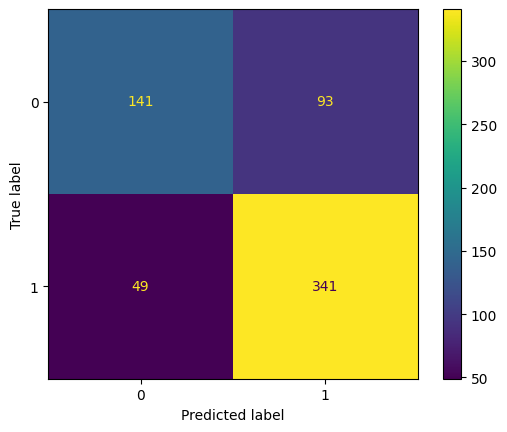

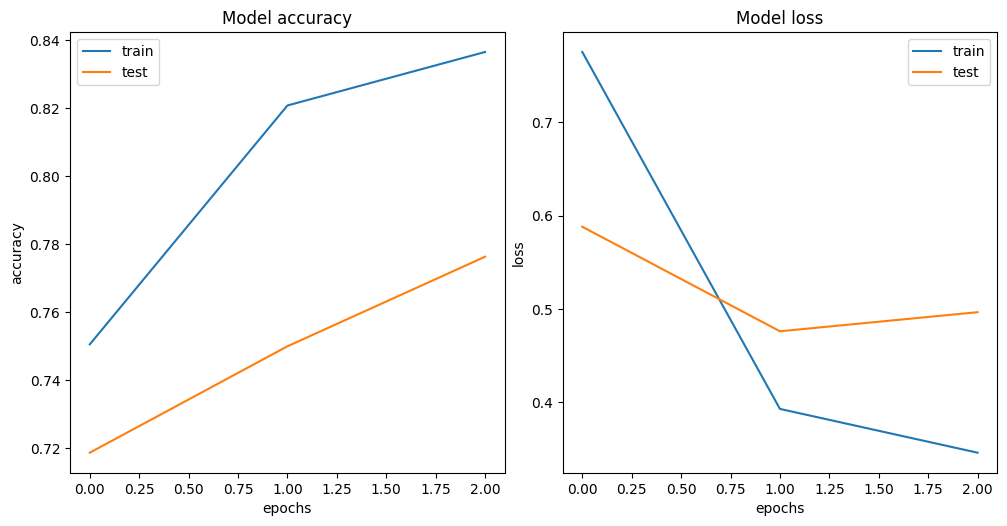

In [59]:
vgg16_model = build_VGG16_model(img_dims, 
                                random_search_results_vgg16.best_params_['units'], 
                                random_search_results_vgg16.best_params_['dropout_rate'])

vgg16_hist = train_model(vgg16_model,
                         train_gen,
                         test_gen,
                        epochs=15,
                        callbacks=[checkpoint, reduce_lr, early_stop])
vgg16_preds, vgg16_test_acc, vgg16_train_acc, vgg16_cr, vgg16_cm, vgg16_cmd = evaluate_model(vgg16_model,
                                                                                            test_data,
                                                                                            test_labels,
                                                                                            vgg16_hist)
show_metrics(vgg16_hist)

In [60]:
print("VGG16 Model Classification Report:")
print(vgg16_cr)

VGG16 Model Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.60      0.67       234
           1       0.79      0.87      0.83       390

    accuracy                           0.77       624
   macro avg       0.76      0.74      0.75       624
weighted avg       0.77      0.77      0.77       624



Resnet Model

/tmp/ipykernel_16744/1243631348.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/15
163/163 [==============================] - 118s 509ms/step - loss: 0.2802 - accuracy: 0.8894 - val_loss: 107.6149 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 77s 474ms/step - loss: 0.1770 - accuracy: 0.9283 - val_loss: 7.5724 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9271
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
20/20 [==============================] - 2s 31ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


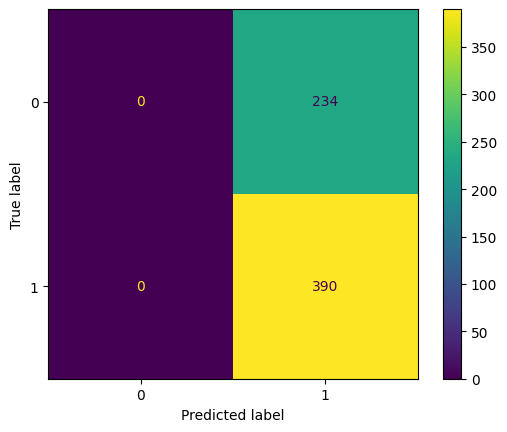

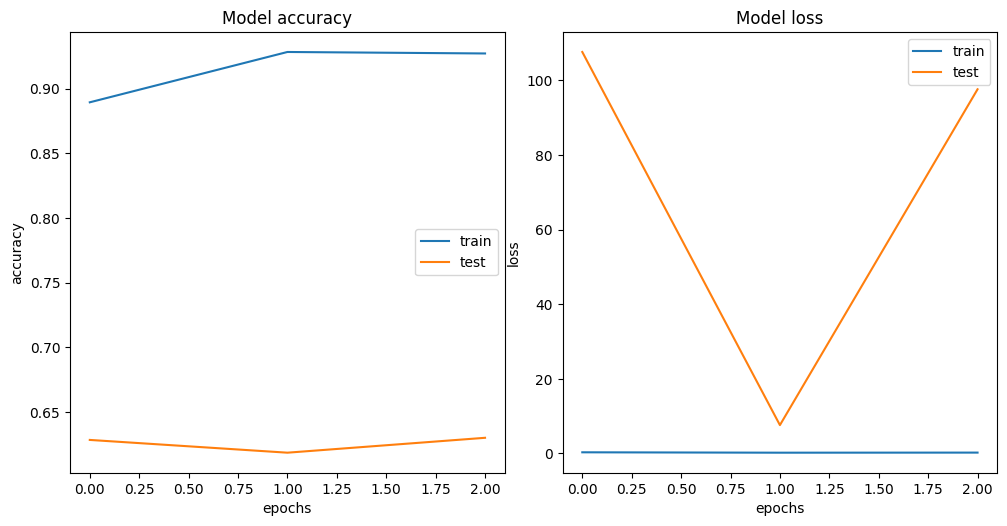

In [61]:
resnet_model = build_ResNet_model(img_dims, 
                                  resnet_random_search_results.best_params_['units'], 
                                  resnet_random_search_results.best_params_['dropout_rate'])

resnet_hist = train_model(resnet_model, 
                          train_gen, 
                          test_gen, 
                          epochs=15,
                          callbacks=[checkpoint, reduce_lr, early_stop])
resnet_preds, resnet_test_acc, resnet_train_acc, resnet_cr, resnet_cm, resnet_cmd = evaluate_model(resnet_model,
               test_data,
               test_labels,
               resnet_hist)

show_metrics(resnet_hist)

In [62]:
print("ResNet Model Classification Report:")
print(resnet_cr)

ResNet Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



# Model Comparison

In [63]:
# Display a table comparing the performance of different models
model_comparison_table = pd.DataFrame({
    'Model': ['CNN', 'VGG16', 'ResNet'],
    'Test Accuracy': [cnn_test_acc, vgg16_test_acc, resnet_test_acc],
    'Train Accuracy': [cnn_train_acc, vgg16_train_acc, resnet_train_acc],
    'Best Parameters': [
        random_search_results_cnn.best_params_,
        random_search_results_vgg16.best_params_,
        resnet_random_search_results.best_params_
    ]
})

print(model_comparison_table)

    Model  Test Accuracy  Train Accuracy                      Best Parameters
0     CNN          62.50            74.0  {'units': 64, 'dropout_rate': 0.25}
1   VGG16          77.24            84.0  {'units': 16, 'dropout_rate': 0.25}
2  ResNet          62.50            93.0  {'units': 16, 'dropout_rate': 0.25}
